In this lab, you will implement the random projection (RP), i.e., Johnson-Lindenstrauss transform. Then, you will compare the two-dimensional visualization results of MNIST data via PCA, PCA after RP, and RP only.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(X, Y), _ = mnist.load_data()
X = X.reshape(X.shape[0], -1).transpose() / 255

# We will only see data of labels 0, 1, 2
target = [0, 1, 2]

# For better visualization and better random projection, we randomly sample
# approximately 10% of data
p = 0.1
idx = np.full(len(Y), False, dtype=bool)
for i in target:
  idx = idx | (Y == i)
r = np.random.choice(a=[True, False], size=X.shape[1], p=[p, 1-p])
idx = idx & r

# The below is our data of interest
X = X[:, idx]
Y = Y[idx]

print("number of samples: {}".format(X.shape[1]))

number of samples: 1890


In [2]:
X.shape, Y.shape

((784, 1890), (1890,))

In [3]:
from sklearn.decomposition import PCA
# Do PCA for our data
pca = PCA(n_components=2)
U = pca.fit_transform(X)

# Compute corresponding low dimensional representations
L = np.matmul(U.transpose(), X)

In [4]:
U.shape, L.shape

((784, 2), (2, 1890))

In [5]:
# This is for visualization
def plot_data(data, colors):
  data = data.transpose()
  plt.rcParams['figure.figsize'] = [7, 7]
  plt.rc('font', size=14)
  for i, color in zip(target, colors):
    subset = data[Y == i]  
    x = [row[0] for row in subset]
    y = [row[1] for row in subset]
    plt.scatter(x, y, c=color, label=i)
  plt.legend()
  plt.show()

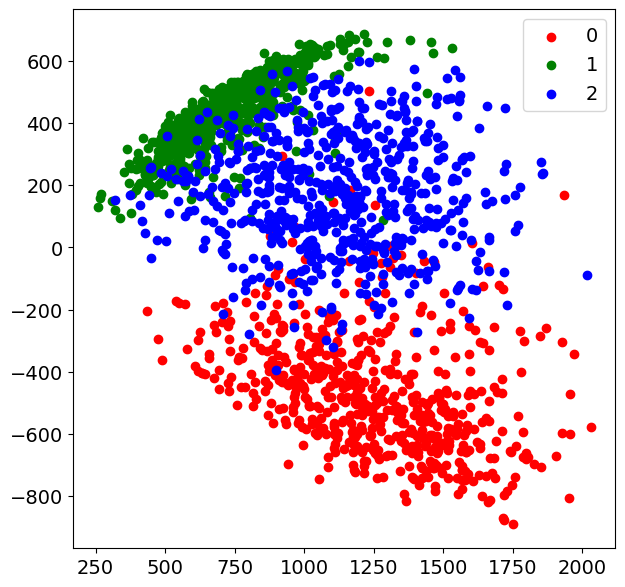

In [6]:
# Visualization via PCA
plot_data(L, ['red','green','blue'])

In [16]:
# Now, lets do PCA again with additional dimension reduction step via random 
# projection
"""TODO: implement the following function."""
def RP_PCA(M: np.ndarray,
           target_dim_rp: int,
           target_dim_pca: int):
    # Here, you will implement RP+PCA. This function first performs RP of 'M' to 
    # 'target_dim' dimensional space. Then it applies PCA for an additional dimension
    # reduction to 'target_dim_pca' space

    # The below indicates input/output of the RP_PCA function.
    # Input
    # M: a matrix of size p x n (each column corresponds to data) where p denotes
    #    the data dimension and n denotes the number of data
    # target_dim_rp: target dimension of RP (typically target_dim_rp <= p)
    # target_dim_pca: target dimension of PCA (typically target_dim_rp <= p)
    # Output
    # M_rp: a matrix of size (target_dim_rp x n) containing the low-dimensional 
    #       representation of data obtained by applying only RP.
    # L_rp: a matrix of size (target_dim_pca x n) containing the low-dimensional 
    #       representation of data obtained by applying RP first, and then PCA next.
    p, n = M.shape
    
    # Check Dimensionality
    k = target_dim_rp
    eps = 1.5
    
    lower_bound: float = (8 *  np.log1p(n)) / (eps ** 2)
    appropriate: bool = k > lower_bound
    if not appropriate:
        print(f"Target dimension {target_dim_rp} may not be suitable "
              f"since dimensional lower bound for JL Lemma is {lower_bound:.0f}")
    
    # Random Matrix for projection
    # Samples from Normal Gaussian, with dimensionality scaling
    R = np.random.normal(loc=0.0, scale=1.0, size=(k, p)) / np.sqrt(k)
    M_rp = R @ M
  
    # Do PCA for our data
    pca = PCA(n_components=target_dim_pca)
    U = pca.fit_transform(M_rp)
    L_rp = np.matmul(U.transpose(), M_rp)
    return M_rp, L_rp

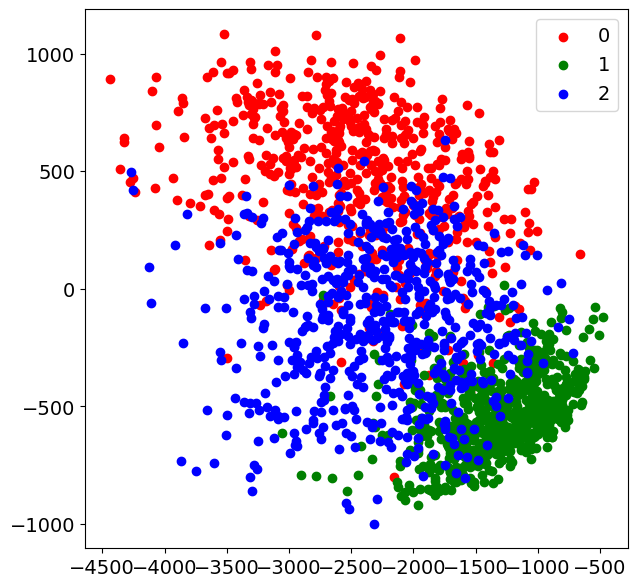

In [17]:
# Visualization via random projection (to 78-dim) + PCA (to 2-dim)
X_rp, L_rp = RP_PCA(X, 78, 2)
plot_data(L_rp, ['red','green','blue'])

Target dimension 2 may not be suitable since dimensional lower bound for JL Lemma is 27


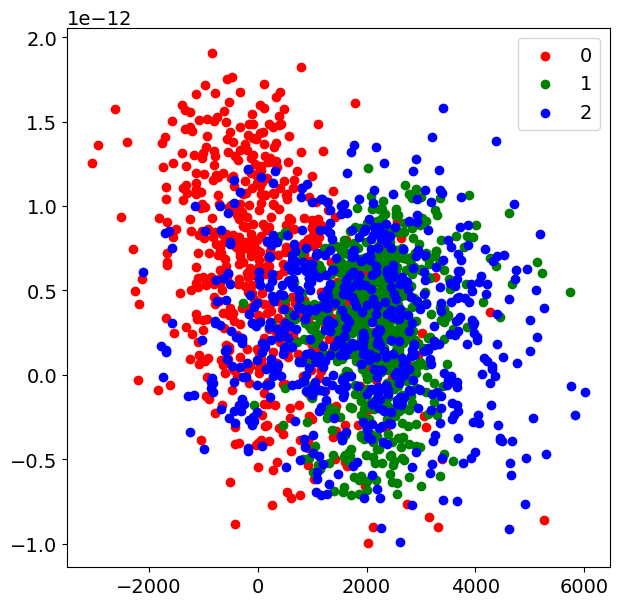

In [18]:
# Visualization via random projection (to 2-dim) + PCA (to 2-dim, i.e., 
# an identity map)
X_rp2, L_rp2 = RP_PCA(X, 2, 2)
plot_data(L_rp2, ['red','green','blue'])

In [10]:
from scipy.spatial import distance

"""TODO: implement the following function."""
def compute_squared_distances(M: np.ndarray,
                              metric: str = "euclidean"):
    """ For a given matrix M: (p, n), calculates pairwise distance of column vectors in M,
    so that the desired output contains distance of all vectors between m_ith and m_jth columns
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
    """
    # Here, you will compute the squared distances between all data in M

    # The below indicates input/output of the compute_squared_distances function.
    # Input
    # M: a matrix of size p x n (each column corresponds to data) where p denotes
    #    the data dimension and n denotes the number of data
    # Output
    # D: an n x n matrix whose (i,j)-th entry contains |mi-mj|^2 where
    #    mi denotes the i-th column of M and '| |' denotes the two norm

    # Caution: Using explicit 'for/while loops' increase the running time.
    #          Try NOT to use loops and write this function only using functions
    #          implemented in numpy/python/other well-implemented libraries.
    #          If you use explicit loops, you will get a lower score.
    D = distance.cdist(XA=M.T, XB=M.T, metric=metric)
    return D

In [19]:
"""TODO: implement the following function."""
def compute_log_dist_ratio(M1: np.ndarray, M2: np.ndarray):
    # Here, you will compute the a vector containing log distance ratio. See the
    # details below.
    # You may use 'compute_squared_distances' function.

    # The below indicates input/output of the compute_squared_distances function.
    # Input
    # M1: a matrix of size p1 x n (each column corresponds to data) where p1 denotes
    #     the data dimension and n denotes the number of data
    # M2: a matrix of size p2 x n (each column corresponds to data) where p2 denotes
    #     the data dimension and n denotes the number of data
    # Output
    # logR: an '(n x (n-1) / 2)'-dimensional vector whose entries are 
    #       log(|m2i-m2j|/|m1i-m1j|) where m1i, m2i denotes the i-th columns of M1
    #       and M2, respectively

    # Namely, logR is a vectorized version of the upper triangular part (excluding
    # the diagonal) of 'log(D1/D2)' where D1 and D2 are squared distance matrices
    # of M1 and M2, and log and division are applied entrywise.

    # In the implementation of 'logR', the order of entries is not important.
    p1, n = M1.shape
    p2, n = M2.shape
    
    D1 = compute_squared_distances(M1, metric="euclidean")
    D1 = D1[np.triu_indices(n=n, k=1)]
    
    D2 = compute_squared_distances(M2, metric="euclidean")
    D2 = D2[np.triu_indices(n=n, k=1)]
    
    logR = np.log(D2 / D1)
    return logR

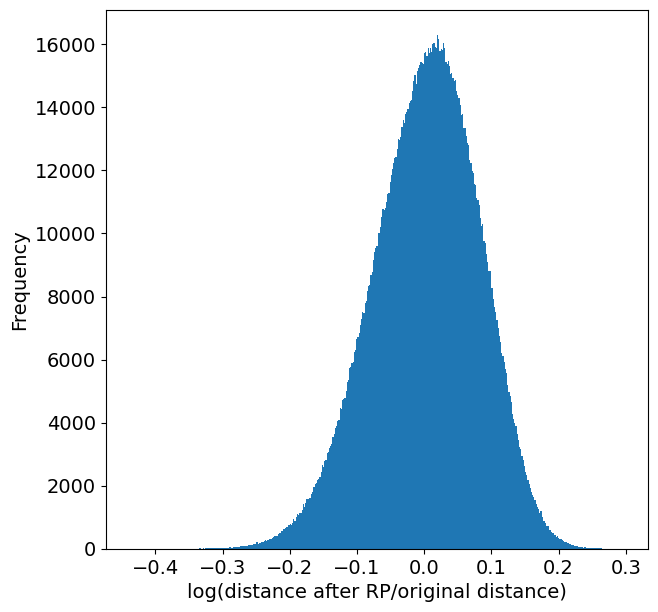

In [20]:
# Plot the histogram for 'log(distance after RP/original distance)'
logR = compute_log_dist_ratio(X, X_rp) # X_rp was computed before via RP_PCA
n, bins, patches = plt.hist(x=logR, bins='auto')
plt.xlabel('log(distance after RP/original distance)')
plt.ylabel('Frequency');